*Text and Sequence*

Loading required libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.datasets import imdb
from keras import preprocessing
from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM,  Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.optimizers import adam
from google.colab import files
import re, os

To avoid the warnings



In [ ]:
# To deprecate warnings that are making the output look clumsy

import logging
logging.getLogger('tensorflow').disabled = True


*Model 1 - Basic Model (To understand how embedding and cutoff works)*
We didn't limit the training, validation and test samples here. I ran a basic model with the entire sample strength to know the model's performance.

In [ ]:

# Considering only top 10,000 Words
max_features = 10000

# Setting a Cut-Off Point for Reviews after 150 Words
maxlen = 150

# Loading the Train and Test Datasets of the IMDB Example
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Pre-Processing to Convert the Texts to Numericals
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

17464789/17464789 [==============================] - 0s 0us/step


Building the network

In [ ]:

# Setting the Sequential Layer for Model Building
model = Sequential()

# Adding the Embedding Layer with limiting to consider only the top 10,000 Words
model.add(Embedding(10000, 8, input_length=maxlen))

# Flattening the Size 
model.add(Flatten())

# Adding the Classifer on the top - As the final layer
model.add(Dense(1, activation = 'sigmoid'))

# Compiling the Model
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])

Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 8)            80000     
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________


Execution

In [ ]:

# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model1.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
Model_1 = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=callbacks)

Epoch 1/30
625/625 [==============================] - 40s 55ms/step - loss: 0.6026 - acc: 0.6971 - val_loss: 0.4344 - val_acc: 0.8278
Epoch 2/30
625/625 [==============================] - 9s 14ms/step - loss: 0.3375 - acc: 0.8644 - val_loss: 0.3256 - val_acc: 0.8626
Epoch 3/30
625/625 [==============================] - 5s 8ms/step - loss: 0.2606 - acc: 0.8956 - val_loss: 0.3025 - val_acc: 0.8722
Epoch 4/30
625/625 [==============================] - 3s 5ms/step - loss: 0.2245 - acc: 0.9128 - val_loss: 0.2995 - val_acc: 0.8724
Epoch 5/30
625/625 [==============================] - 3s 5ms/step - loss: 0.1993 - acc: 0.9242 - val_loss: 0.3052 - val_acc: 0.8716
Epoch 6/30
625/625 [==============================] - 4s 6ms/step - loss: 0.1776 - acc: 0.9344 - val_loss: 0.3073 - val_acc: 0.8724
Epoch 7/30
625/625 [==============================] - 8s 13ms/step - loss: 0.1582 - acc: 0.9434 - val_loss: 0.3182 - val_acc: 0.8696
Epoch 8/30
625/625 [==============================] - 7s 11ms/step - los

Visualizing Training and Validation Loss and Accuracy



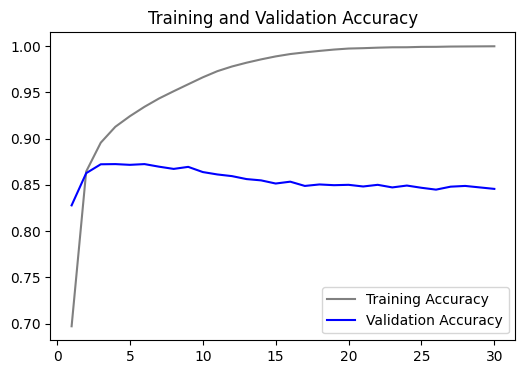

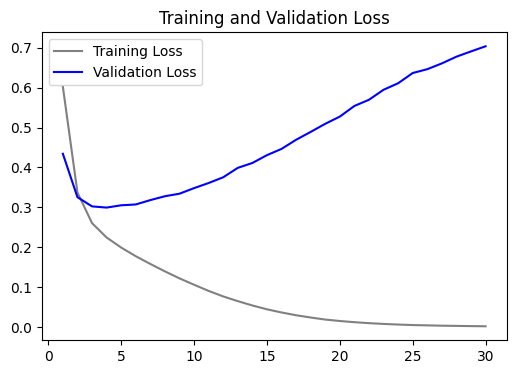

In [ ]:
accuracy = Model_1.history['acc']
val_accuracy = Model_1.history['val_acc']

loss = Model_1.history["loss"]
val_loss = Model_1.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = load_model('model1.keras')
Model1_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {Model1_Results[0]:.3f}')
print(f'Accuracy: {Model1_Results[1]:.3f}')

782/782 [==============================] - 2s 2ms/step - loss: 0.2945 - acc: 0.8748
Loss: 0.294
Accuracy: 0.875



Initially, a model was trained without limiting the training, validation, and test samples, and achieved an accuracy of 87.5%.

Now, the goal is to build models with limited samples to understand the impact of the amount of training data on the model's performance.

*Model 2 Training Sample - 100, Validation Sample - 10000, Test Sample - 5000*


Creating Custom Samples of Train, Validation and Test Set



In [ ]:
# Setting the maximum number of words to be used in the vocabulary
num_words = 10000

# Loading the IMDB Dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

# Cut-Off the reviews after 150 words
maxlen = 150
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

# Combining the Training and Testing data create an entire dataset
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data into Training and Validation Samples
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=100, test_size=10000, random_state=42, stratify=labels)

# Further split the data to get the test size of 5000 samples
_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

We could verify the custom splits provided by looking at the below code where we are looking at the train, validation and test data.



In [ ]:
train_texts.shape


(100, 150)

In [ ]:
val_texts.shape


(10000, 150)

In [ ]:
test_texts.shape


(5000, 150)


Building the Network

We didn't change the network here, we wanted to use just the embedding layer to assess the model performance.

In [ ]:
# Setting the Sequential Layer for Model Building
model = Sequential()

# Adding the Embedding Layer with limiting to consider only the top 10,000 Words
model.add(Embedding(10000, 8, input_length=maxlen))

# Flattening the Size 
model.add(Flatten())

# Adding the Classifer on the top - As the final layer
model.add(Dense(1, activation = 'sigmoid'))

# Compiling the Model
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])

Summary

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten_1 (Flatten)         (None, 1200)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________


Execution 

In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model2.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
Model_2 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels), 
                    callbacks=callbacks)

Epoch 1/30
4/4 [==============================] - 2s 366ms/step - loss: 0.6939 - acc: 0.5100 - val_loss: 0.6934 - val_acc: 0.4951
Epoch 2/30
4/4 [==============================] - 2s 595ms/step - loss: 0.6720 - acc: 0.8900 - val_loss: 0.6931 - val_acc: 0.5040
Epoch 3/30
4/4 [==============================] - 1s 357ms/step - loss: 0.6566 - acc: 0.9400 - val_loss: 0.6932 - val_acc: 0.5037
Epoch 4/30
4/4 [==============================] - 1s 324ms/step - loss: 0.6428 - acc: 0.9800 - val_loss: 0.6930 - val_acc: 0.5078
Epoch 5/30
4/4 [==============================] - 1s 297ms/step - loss: 0.6297 - acc: 0.9900 - val_loss: 0.6930 - val_acc: 0.5093
Epoch 6/30
4/4 [==============================] - 1s 327ms/step - loss: 0.6161 - acc: 0.9900 - val_loss: 0.6929 - val_acc: 0.5141
Epoch 7/30
4/4 [==============================] - 1s 309ms/step - loss: 0.6028 - acc: 0.9900 - val_loss: 0.6928 - val_acc: 0.5126
Epoch 8/30
4/4 [==============================] - 1s 332ms/step - loss: 0.5892 - acc: 0.99

Visualizing Training and Validation Loss/Accuracy



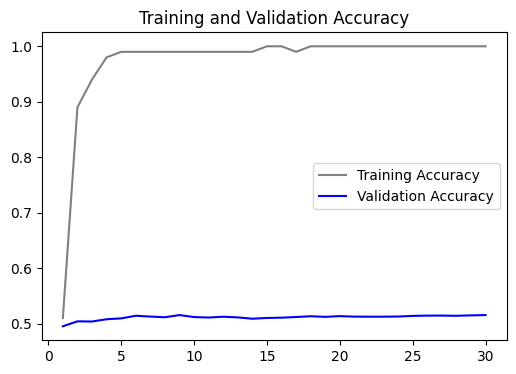

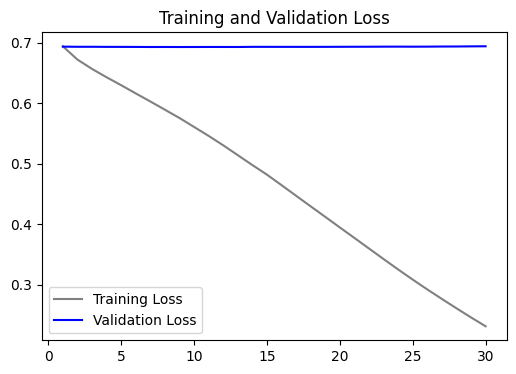

In [ ]:
accuracy = Model_2.history['acc']
val_accuracy = Model_2.history['val_acc']

loss = Model_2.history["loss"]
val_loss = Model_2.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluating the Model on Test Set



In [ ]:
test_model = load_model('model2.keras')
Model2_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model2_Results[0]:.3f}')
print(f'Accuracy: {Model2_Results[1]:.3f}')

157/157 [==============================] - 0s 2ms/step - loss: 0.6923 - acc: 0.5134
Loss: 0.692
Accuracy: 0.513


The model with 100 training samples which was built with just an embedding layer resulted in 51.3% Accuracy, which is not that bad because the model was just trained with 100 Samples


*Model 3 Using Conv1D and Embedding Layer Together*
Training - 1000, Validation - 10000 and Test - 5000

In [ ]:
# Setting the maximum number of words to be used in the vocabulary
num_words = 10000

# Loading the IMDB Dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

# Cut-Off the reviews after 150 words
maxlen = 150
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

# Combining the Training and Testing data create an entire dataset
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data into Training and Validation Samples
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=1000, test_size=10000, random_state=42, stratify=labels)

# Further split the data to get the test size of 5000 samples
_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)
     

Confirming the sizes of the train, validate and test datasets

In [ ]:
train_texts.shape


(1000, 150)

In [ ]:
val_texts.shape


(10000, 150)

In [ ]:
test_texts.shape


(5000, 150)

 Conv1D with Embedding

In [ ]:
# Setting the Sequential Layer for Model Building
model = Sequential()

# Adding the Embedding Layer with limiting to consider only the top 10,000 Words
maxlen = 150
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.8))
model.add(MaxPooling1D(3))

model.add(GlobalMaxPooling1D())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# Compiling the Model
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

Summary

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 8)            80000     
                                                                 
 conv1d (Conv1D)             (None, 148, 512)          12800     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 256)           393472    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 256)          

Running the Model



In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model3.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
Model_3 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels), 
                    callbacks=callbacks)

Epoch 1/30
32/32 [==============================] - 17s 311ms/step - loss: 0.6945 - accuracy: 0.4910 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 2/30
32/32 [==============================] - 7s 209ms/step - loss: 0.6932 - accuracy: 0.5050 - val_loss: 0.6931 - val_accuracy: 0.5307
Epoch 3/30
32/32 [==============================] - 6s 190ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5033
Epoch 4/30
32/32 [==============================] - 7s 228ms/step - loss: 0.6933 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/30
32/32 [==============================] - 3s 92ms/step - loss: 0.6928 - accuracy: 0.5130 - val_loss: 0.6930 - val_accuracy: 0.5094
Epoch 6/30
32/32 [==============================] - 4s 135ms/step - loss: 0.6919 - accuracy: 0.5160 - val_loss: 0.6929 - val_accuracy: 0.5484
Epoch 7/30
32/32 [==============================] - 5s 168ms/step - loss: 0.6913 - accuracy: 0.5310 - val_loss: 0.6927 - val_accuracy: 0.5203
Epoch 

Visualizing the Training and Validation Loss/Accuracy



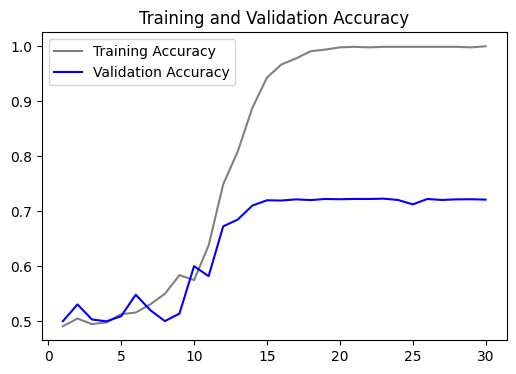

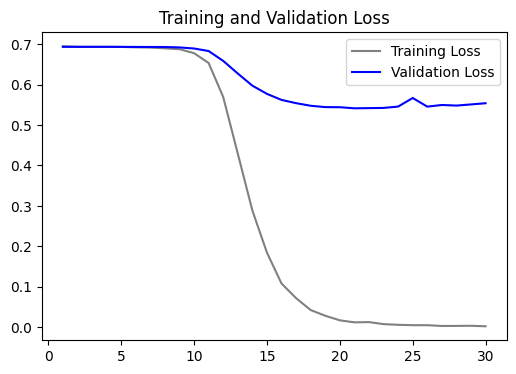

In [ ]:
accuracy = Model_3.history['accuracy']
val_accuracy = Model_3.history['val_accuracy']

loss = Model_3.history["loss"]
val_loss = Model_3.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluation

In [ ]:
test_model = load_model('model3.keras')
Model3_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model3_Results[0]:.3f}')
print(f'Accuracy: {Model3_Results[1]:.3f}')

157/157 [==============================] - 1s 4ms/step - loss: 0.5287 - accuracy: 0.7374
Loss: 0.529
Accuracy: 0.737


This is interesting to observe as soon as we increase the training sample size to 1000 and by building a complex network i.e. using Conv1D along with Embedding actually resulted in 73.7% Accuracy.


*Model 4 Conv1D and Embedding Layer Together With Change in network*
Training - 25000, Validation - 10000 and Test - 5000

In [ ]:
# Setting the maximum number of words to be used in the vocabulary
num_words = 10000

# Loading the IMDB Dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

# Cut-Off the reviews after 150 words
maxlen = 150
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

# Combining the Training and Testing data create an entire dataset
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data into Training and Validation Samples
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=25000, test_size=10000, random_state=42, stratify=labels)

# Further split the data to get the test size of 5000 samples
_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

Verifying the size of the training, validation and test datsets



In [ ]:
train_texts.shape


(25000, 150)

In [ ]:
val_texts.shape


(10000, 150)

In [ ]:
test_texts.shape


(5000, 150)

Building the Network

We are adding an additional layer to both the Conv1D as well as the dense network, we also changed the embedding vector dimension to 12 and added dropout layers to all the input layers so as to avoid overfitting

In [ ]:
# Setting the Sequential Layer for Model Building
model = Sequential()

# Adding the Embedding Layer with limiting to consider only the top 10,000 Words
maxlen = 150
model.add(Embedding(10000, 12, input_length=maxlen))

model.add(Conv1D(512, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(128, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(GlobalMaxPooling1D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


# Compiling the Model
adam = keras.optimizers.Adam(learning_rate = 0.0002)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
     

Summary

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 12)           120000    
                                                                 
 conv1d_3 (Conv1D)           (None, 148, 512)          18944     
                                                                 
 dropout_1 (Dropout)         (None, 148, 512)          0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 74, 512)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 72, 256)           393472    
                                                                 
 dropout_2 (Dropout)         (None, 72, 256)           0         
                                                      

Running the model

In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model4.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
Model_4 = model.fit(train_texts, train_labels,
                    epochs=50,
                    batch_size=64,
                    validation_data=(val_texts, val_labels), 
                    callbacks=callbacks)

Epoch 1/50
391/391 [==============================] - 57s 135ms/step - loss: 0.6935 - accuracy: 0.5049 - val_loss: 0.6931 - val_accuracy: 0.5156
Epoch 2/50
391/391 [==============================] - 18s 47ms/step - loss: 0.6682 - accuracy: 0.5576 - val_loss: 0.5771 - val_accuracy: 0.7866
Epoch 3/50
391/391 [==============================] - 11s 27ms/step - loss: 0.3852 - accuracy: 0.8322 - val_loss: 0.5183 - val_accuracy: 0.8422
Epoch 4/50
391/391 [==============================] - 9s 22ms/step - loss: 0.2902 - accuracy: 0.8810 - val_loss: 0.4614 - val_accuracy: 0.8367
Epoch 5/50
391/391 [==============================] - 10s 27ms/step - loss: 0.2437 - accuracy: 0.9033 - val_loss: 0.4627 - val_accuracy: 0.8493
Epoch 6/50
391/391 [==============================] - 8s 20ms/step - loss: 0.2085 - accuracy: 0.9186 - val_loss: 0.4117 - val_accuracy: 0.8483
Epoch 7/50
391/391 [==============================] - 8s 22ms/step - loss: 0.1801 - accuracy: 0.9324 - val_loss: 0.3930 - val_accuracy: 0

Visualizing the Training and Validation Loss/Accuracy



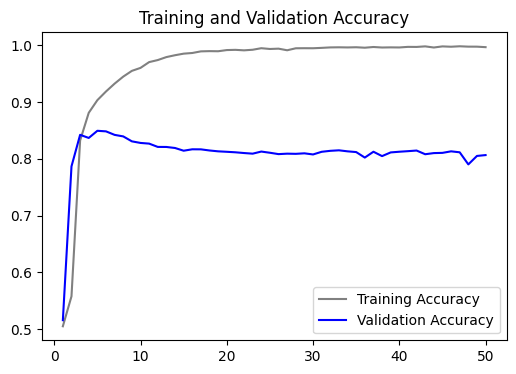

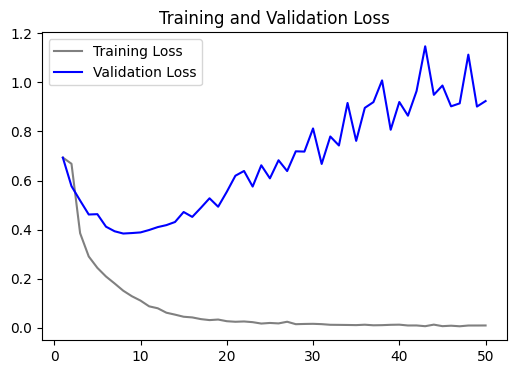

In [ ]:
accuracy = Model_4.history['accuracy']
val_accuracy = Model_4.history['val_accuracy']

loss = Model_4.history["loss"]
val_loss = Model_4.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()
     

Test set

In [ ]:
test_model = load_model('model4.keras')
Model4_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model4_Results[0]:.3f}')
print(f'Accuracy: {Model4_Results[1]:.3f}')

157/157 [==============================] - 1s 6ms/step - loss: 0.3169 - accuracy: 0.8978
Loss: 0.317
Accuracy: 0.898


We designed a more intricate neural network by augmenting the input layers of the Conv1D and incorporating Dropout for each layer to prevent overfitting.

Additionally, we added two dense layers with Dropout and used Adam optimizer with a learning rate of 0.0002. We trained this network with 25,000 samples and achieved an accuracy of 89.8%.

*Model 5 Conv1D and Embedding Layer with Change in Embedding Vector*
Training - 35000, Validation - 10000 and Test - 5000

In [ ]:
# Setting the maximum number of words to be used in the vocabulary
num_words = 10000

# Loading the IMDB Dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

# Cut-Off the reviews after 150 words
maxlen = 150
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

# Combining the Training and Testing data create an entire dataset
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data into Training and Validation Samples
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=35000, test_size=10000, random_state=42, stratify=labels)

# Further split the data to get the test size of 5000 samples
_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

Verifying the sizes of training, validation and test datasets



In [ ]:
train_texts.shape


(35000, 150)

In [ ]:
val_texts.shape


(10000, 150)

In [ ]:
test_texts.shape


(5000, 150)

Building the Network

Everything is same like the previous model, just we changed the embedding vector size to 14 from 12.


In [ ]:
# Setting the Sequential Layer for Model Building
model = Sequential()

# Adding the Embedding Layer with limiting to consider only the top 10,000 Words
maxlen = 150
model.add(Embedding(10000, 14, input_length=maxlen))

model.add(Conv1D(512, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(128, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(GlobalMaxPooling1D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


# Compiling the Model
adam = keras.optimizers.Adam(learning_rate = 0.0002)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

Summary

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 14)           140000    
                                                                 
 conv1d_11 (Conv1D)          (None, 148, 512)          22016     
                                                                 
 dropout_13 (Dropout)        (None, 148, 512)          0         
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 74, 512)          0         
 g1D)                                                            
                                                                 
 conv1d_12 (Conv1D)          (None, 72, 256)           393472    
                                                                 
 dropout_14 (Dropout)        (None, 72, 256)           0         
                                                      

Running the model

In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model5.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
Model_5 = model.fit(train_texts, train_labels,
                    epochs=50,
                    batch_size=64,
                    validation_data=(val_texts, val_labels), 
                    callbacks=callbacks)

Epoch 1/50
547/547 [==============================] - 63s 110ms/step - loss: 0.6872 - accuracy: 0.5229 - val_loss: 0.6474 - val_accuracy: 0.5938
Epoch 2/50
547/547 [==============================] - 18s 33ms/step - loss: 0.4001 - accuracy: 0.8206 - val_loss: 0.5005 - val_accuracy: 0.8499
Epoch 3/50
547/547 [==============================] - 14s 25ms/step - loss: 0.2965 - accuracy: 0.8765 - val_loss: 0.4443 - val_accuracy: 0.8540
Epoch 4/50
547/547 [==============================] - 11s 20ms/step - loss: 0.2567 - accuracy: 0.8946 - val_loss: 0.4326 - val_accuracy: 0.8564
Epoch 5/50
547/547 [==============================] - 11s 21ms/step - loss: 0.2262 - accuracy: 0.9109 - val_loss: 0.4051 - val_accuracy: 0.8421
Epoch 6/50
547/547 [==============================] - 11s 19ms/step - loss: 0.2050 - accuracy: 0.9194 - val_loss: 0.4106 - val_accuracy: 0.8338
Epoch 7/50
547/547 [==============================] - 10s 19ms/step - loss: 0.1797 - accuracy: 0.9316 - val_loss: 0.3842 - val_accuracy

Visualizing the Training and Validation Loss/Accuracy



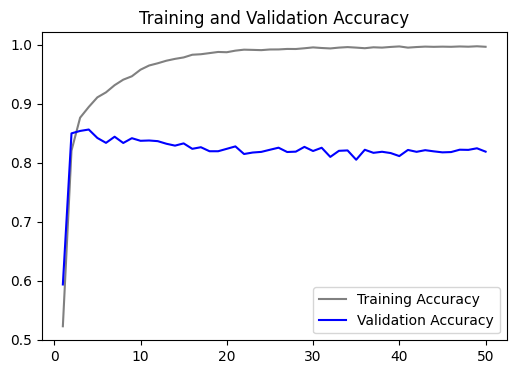

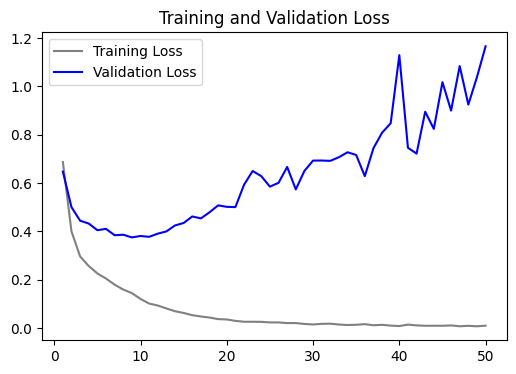

In [ ]:

accuracy = Model_5.history['accuracy']
val_accuracy = Model_5.history['val_accuracy']

loss = Model_5.history["loss"]
val_loss = Model_5.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluating the Model on Test Set



In [ ]:
test_model = load_model('model5.keras')
Model5_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model5_Results[0]:.3f}')
print(f'Accuracy: {Model5_Results[1]:.3f}')

157/157 [==============================] - 1s 5ms/step - loss: 0.2683 - accuracy: 0.9246
Loss: 0.268
Accuracy: 0.925


By simply adjusting the embedding vector dimension from 12 to 14 and increasing the training samples to over 10,000, we were able to improve the accuracy of our model. In fact, Model 5, which utilized these changes, proved to be the best with the highest accuracy of 92.5%.

It's important to note that the embedding vector dimension is just one of many key hyperparameters that can be adjusted to optimize the network. Other parameters include the learning rate, dropout rate, and the number of input conv1d and dense layers. However, it's crucial to find the right balance when setting these hyperparameters to prevent overfitting or underfitting.

We developed four different models for the embedding part, namely Model 2, Model 3, Model 4, and Model 5. Model 1 was considered the base model and was not included in our evaluation of the best performing model.

*Evaluating the Best Model - Embedding Base Models*

In [ ]:

Models = ['Mod 2', 'Mod 3', 'Mod 4', 'Mod5']
Loss = [0.693,0.524,0.290,0.257]
Accuracy = [0.517,0.744,0.908,0.926]


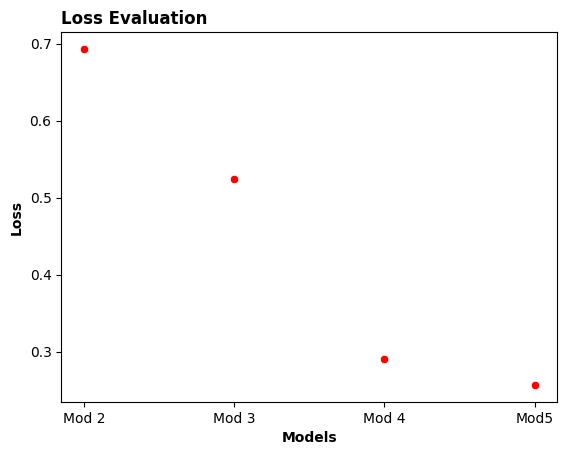

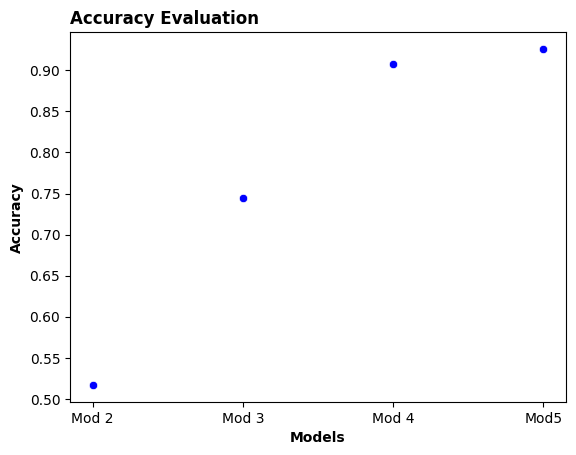

In [ ]:
# Loss Evaluation
sns.scatterplot(x=Models, y=Loss,color='red')
plt.xlabel("Models",fontdict={"size":10,"weight":'bold'})
plt.ylabel("Loss",fontdict={"size":10,"weight":'bold'})
plt.title("Loss Evaluation",loc='left',fontdict={"size":12,"weight":'bold'})
plt.show()

# Accuracy Evaluation
sns.scatterplot(x=Models, y=Accuracy,color='blue')
plt.xlabel("Models",fontdict={"size":10,"weight":'bold'})
plt.ylabel("Accuracy",fontdict={"size":10,"weight":'bold'})
plt.title("Accuracy Evaluation",loc='left',fontdict={"size":12,"weight":'bold'})
plt.show()
     

*We can clearly observe that Model 5 is the best model among the base embedding models with highest accuracy of around 92.6%.*

*This accuracy was obtained when the training sample was set to 35000, validation to 10000 and test to 5000. We used Conv1D and Embedding Layer together, the network architecture can be referred by looking at the model summary.*

*Pre-Trained Models*
*Pretrained Word Embedding Model GloVe*
*PreTrained Model 1 with Training Samples of 1000*
Loading in the IMDB .tar file to the colab environment

In [ ]:

!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
     

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  21.0M      0  0:00:03  0:00:03 --:--:-- 21.0M


In [ ]:
!rm -r aclImdb/train/unsup


rm: cannot remove 'aclImdb/train/unsup': No such file or directory


Creating Directories and Appending the data further from Neg and Pos Class of the Data



In [ ]:
imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

Looking at the total samples in the train class



In [ ]:
print('No. of Samples', len(texts))


No. of Samples 25000


Preparing data for modelling and creating train and validation sets



In [ ]:

maxlen = 150  # cutting off reviews after 150 words
training_samples = 100  # training on 100 samples
validation_samples = 10000  # validating on 10000 samples
max_words = 10000  # considering the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splitting the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
     

Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


Verifying the size of the train and validation samples



In [ ]:
x_train.shape


(100, 150)

In [ ]:
x_val.shape


(10000, 150)

Mounting google drive so as to acess the glove.txt file

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
glove_dir = '/content/gdrive/MyDrive/Glove'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Creating a embedding matrix



In [ ]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
     

Building the Network



In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Compiling the Model
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

Summary

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,017,057
Trainable params: 17,057
Non-trainable params: 1,000,000
_________________________________________________________________


Running the model

In [ ]:
# Setting Callbacks
callbacks=callbacks = ModelCheckpoint(
            filepath= "premodel1.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Pre_Model_1 =  model.fit(x_train, y_train, 
                     epochs=30, 
                     batch_size=32, 
                     validation_data=(x_val, y_val),
                     callbacks=callbacks)

Epoch 1/30
4/4 [==============================] - 6s 588ms/step - loss: 0.7369 - accuracy: 0.5800 - val_loss: 0.8193 - val_accuracy: 0.5000
Epoch 2/30
4/4 [==============================] - 3s 883ms/step - loss: 0.7258 - accuracy: 0.5800 - val_loss: 0.8061 - val_accuracy: 0.5000
Epoch 3/30
4/4 [==============================] - 1s 454ms/step - loss: 0.7194 - accuracy: 0.5800 - val_loss: 0.7939 - val_accuracy: 0.4998
Epoch 4/30
4/4 [==============================] - 1s 444ms/step - loss: 0.7111 - accuracy: 0.5800 - val_loss: 0.7838 - val_accuracy: 0.4998
Epoch 5/30
4/4 [==============================] - 1s 375ms/step - loss: 0.7054 - accuracy: 0.5800 - val_loss: 0.7745 - val_accuracy: 0.4996
Epoch 6/30
4/4 [==============================] - 1s 446ms/step - loss: 0.7002 - accuracy: 0.5800 - val_loss: 0.7679 - val_accuracy: 0.4992
Epoch 7/30
4/4 [==============================] - 1s 444ms/step - loss: 0.6971 - accuracy: 0.5800 - val_loss: 0.7632 - val_accuracy: 0.4995
Epoch 8/30
4/4 [====

Visualizing the Training and Validation Loss/Accuracy



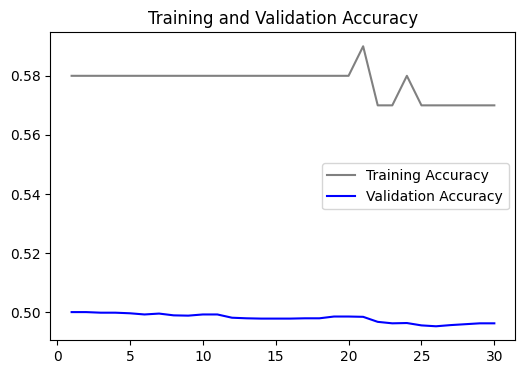

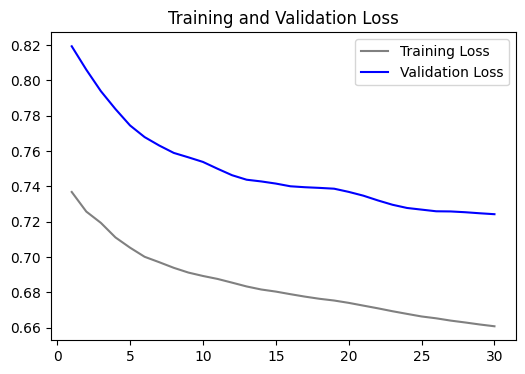

In [ ]:
accuracy = Pre_Model_1.history['accuracy']
val_accuracy = Pre_Model_1.history['val_accuracy']

loss = Pre_Model_1.history["loss"]
val_loss = Pre_Model_1.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Loading the test data for model evaluation



In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)[:5000]
y_test = np.asarray(labels)[:5000]

In [ ]:
x_test.shape


(5000, 150)

Model Evaluation 

In [ ]:
test_model = load_model('premodel1.keras')
PreModel1_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {PreModel1_Results[0]:.3f}')
print(f'Accuracy: {PreModel1_Results[1]:.3f}')

157/157 [==============================] - 2s 6ms/step - loss: 0.9254 - accuracy: 0.0524
Loss: 0.925
Accuracy: 0.052


With 100 Training Samples the model thus built using the weights of the pre-trained model resulted in poor accuracy i.e. of 52.0%.



*PreTrained Model 2 with Training Samples of 1000*


In [ ]:
maxlen = 150  # cutting off reviews after 150 words
training_samples = 1000  # training on 1000 samples
validation_samples = 10000  # validating on 10000 samples
max_words = 10000  # considering the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splitting the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 87393 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


In [ ]:
x_train.shape


(1000, 150)

In [ ]:
x_val.shape


(10000, 150)

Building the Network

Compared to the previous model the network architecture thus built is very strong by having more input layers and dropout and dense layers


In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


# Compiling the Model
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 lstm_1 (LSTM)               (None, 150, 512)          1255424   
                                                                 
 dropout_19 (Dropout)        (None, 150, 512)          0         
                                                                 
 lstm_2 (LSTM)               (None, 150, 256)          787456    
                                                                 
 dropout_20 (Dropout)        (None, 150, 256)          0         
                                                                 
 lstm_3 (LSTM)               (None, 150, 128)          197120    
                                                                 
 dropout_21 (Dropout)        (None, 150, 128)         

In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "premodel2.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Pre_Model_2 =  model.fit(x_train, y_train, 
                     epochs=40, 
                     batch_size=32, 
                     validation_data=(x_val, y_val),
                     callbacks=callbacks)

Epoch 1/40
32/32 [==============================] - 19s 324ms/step - loss: 0.6925 - accuracy: 0.5400 - val_loss: 0.6932 - val_accuracy: 0.4949
Epoch 2/40
32/32 [==============================] - 7s 231ms/step - loss: 0.7000 - accuracy: 0.4600 - val_loss: 0.6929 - val_accuracy: 0.5050
Epoch 3/40
32/32 [==============================] - 7s 235ms/step - loss: 0.6918 - accuracy: 0.5320 - val_loss: 0.6945 - val_accuracy: 0.4950
Epoch 4/40
32/32 [==============================] - 7s 226ms/step - loss: 0.6962 - accuracy: 0.5030 - val_loss: 0.6928 - val_accuracy: 0.5050
Epoch 5/40
32/32 [==============================] - 12s 376ms/step - loss: 0.6936 - accuracy: 0.5060 - val_loss: 0.6935 - val_accuracy: 0.4950
Epoch 6/40
32/32 [==============================] - 12s 376ms/step - loss: 0.6933 - accuracy: 0.5060 - val_loss: 0.6932 - val_accuracy: 0.4950
Epoch 7/40
32/32 [==============================] - 12s 381ms/step - loss: 0.6953 - accuracy: 0.5250 - val_loss: 0.6930 - val_accuracy: 0.4949
Ep

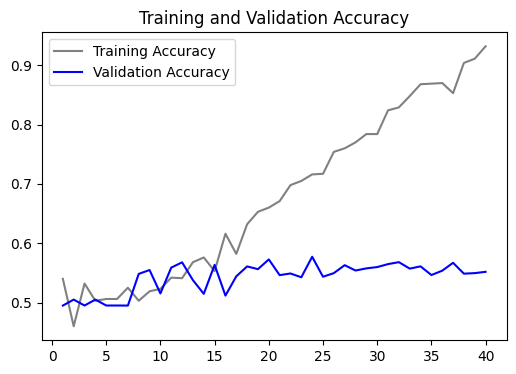

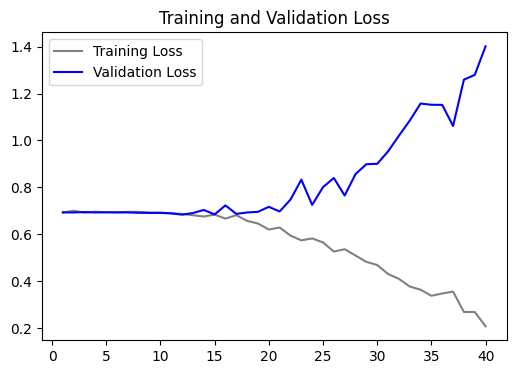

In [ ]:
accuracy = Pre_Model_2.history['accuracy']
val_accuracy = Pre_Model_2.history['val_accuracy']

loss = Pre_Model_2.history["loss"]
val_loss = Pre_Model_2.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Loading the Test Dataset

Limiting the size of the test samples to 5000

In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)[:5000]
y_test = np.asarray(labels)[:5000]

Model Evaluation



In [ ]:
test_model = load_model('premodel2.keras')
PreModel2_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {PreModel2_Results[0]:.3f}')
print(f'Accuracy: {PreModel2_Results[1]:.3f}')

157/157 [==============================] - 5s 20ms/step - loss: 0.6751 - accuracy: 0.6164
Loss: 0.675
Accuracy: 0.616


The accuracy thus achieved with 1000 training samples and a complex network architecture than the prior model led to a spike in accuracy to 61.6%

*PreTrained Model 3 with 10000 Training Samples*


In [ ]:
maxlen = 150  # cutting off reviews after 150 words
training_samples = 10000  # training on 10000 samples
validation_samples = 10000  # validating on 10000 samples
max_words = 10000  # considering the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splitting the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 87393 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


Verifying the size of train and validation samples

In [ ]:
x_train.shape


(10000, 150)

In [ ]:
x_val.shape


(10000, 150)

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

model.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Compiling the Model
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 lstm_5 (LSTM)               (None, 150, 64)           42240     
                                                                 
 lstm_6 (LSTM)               (None, 32)                12416     
                                                                 
 dense_17 (Dense)            (None, 64)                2112      
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,056,833
Trainable params: 56,833
Non-t

In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "premodel3.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Pre_Model_3 =  model.fit(x_train, y_train, 
                     epochs=40, 
                     batch_size=64, 
                     validation_data=(x_val, y_val),
                     callbacks=callbacks)
     

Epoch 1/40
157/157 [==============================] - 274s 2s/step - loss: 0.6948 - accuracy: 0.5111 - val_loss: 0.6912 - val_accuracy: 0.5035
Epoch 2/40
157/157 [==============================] - 288s 2s/step - loss: 0.6899 - accuracy: 0.5342 - val_loss: 0.6796 - val_accuracy: 0.5740
Epoch 3/40
157/157 [==============================] - 261s 2s/step - loss: 0.6787 - accuracy: 0.5696 - val_loss: 0.6563 - val_accuracy: 0.6216
Epoch 4/40
157/157 [==============================] - 241s 2s/step - loss: 0.6784 - accuracy: 0.5780 - val_loss: 0.6957 - val_accuracy: 0.5354
Epoch 5/40
157/157 [==============================] - 233s 1s/step - loss: 0.6426 - accuracy: 0.6353 - val_loss: 0.6257 - val_accuracy: 0.6452
Epoch 6/40
157/157 [==============================] - 224s 1s/step - loss: 0.6105 - accuracy: 0.6720 - val_loss: 0.6007 - val_accuracy: 0.6776
Epoch 7/40
157/157 [==============================] - 229s 1s/step - loss: 0.5940 - accuracy: 0.6858 - val_loss: 0.5776 - val_accuracy: 0.6949

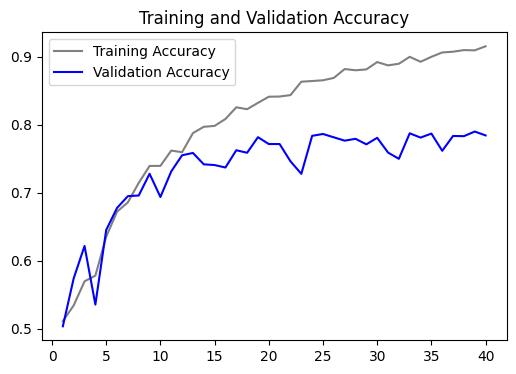

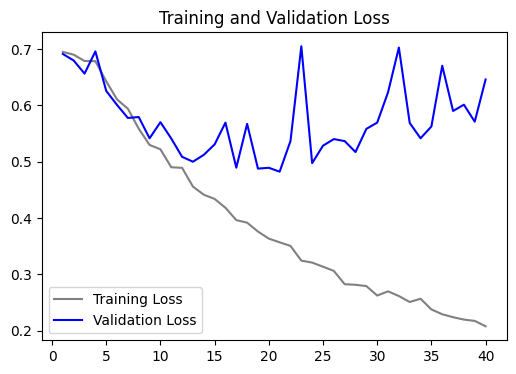

In [ ]:
accuracy = Pre_Model_3.history['accuracy']
val_accuracy = Pre_Model_3.history['val_accuracy']

loss = Pre_Model_3.history["loss"]
val_loss = Pre_Model_3.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Since the test data is already loaded in the previous iteration we aren't loading the test data here, the test data size is 5000 samples, which can be verified in the below cell.



In [ ]:
x_test.shape


(5000, 150)

Evaluating the Model Performance on the Test Set



In [ ]:
test_model = load_model('premodel3.keras')
PreModel3_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {PreModel3_Results[0]:.3f}')
print(f'Accuracy: {PreModel3_Results[1]:.3f}')

157/157 [==============================] - 16s 100ms/step - loss: 0.3269 - accuracy: 0.8572
Loss: 0.327
Accuracy: 0.857


Upon continous experiments and changing the network this was the best accuracy thus achieved when the training sample size was set to 10000.

*PreModel 4 with Training Samples of 15000*


In [ ]:
maxlen = 150  # cutting off reviews after 150 words
training_samples = 15000  # training on 15000 samples
validation_samples = 10000  # validating on 10000 samples
max_words = 10000  # considering the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splitting the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Verifying the sample sizes of Training and Validation Set



In [ ]:
x_train.shape


In [ ]:
x_val.shape


In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Compiling the Model
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 lstm_7 (LSTM)               (None, 150, 256)          365568    
                                                                 
 dropout_25 (Dropout)        (None, 150, 256)          0         
                                                                 
 lstm_8 (LSTM)               (None, 150, 128)          197120    
                                                                 
 dropout_26 (Dropout)        (None, 150, 128)          0         
                                                                 
 lstm_9 (LSTM)               (None, 128)               131584    
                                                                 
 dense_19 (Dense)            (None, 256)              

In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "premodel4.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Pre_Model_4 =  model.fit(x_train, y_train, 
                     epochs=40, 
                     batch_size=64, 
                     validation_data=(x_val, y_val),
                     callbacks=callbacks)

Epoch 1/40
235/235 [==============================] - 17s 48ms/step - loss: 0.6943 - accuracy: 0.5037 - val_loss: 0.6936 - val_accuracy: 0.4962
Epoch 2/40
235/235 [==============================] - 9s 39ms/step - loss: 0.6939 - accuracy: 0.5030 - val_loss: 0.6935 - val_accuracy: 0.4963
Epoch 3/40
235/235 [==============================] - 9s 39ms/step - loss: 0.6936 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 4/40
235/235 [==============================] - 9s 39ms/step - loss: 0.6936 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5033
Epoch 5/40
235/235 [==============================] - 9s 38ms/step - loss: 0.6934 - accuracy: 0.5067 - val_loss: 0.6930 - val_accuracy: 0.5069
Epoch 6/40
235/235 [==============================] - 10s 41ms/step - loss: 0.6936 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.5025
Epoch 7/40
235/235 [==============================] - 10s 41ms/step - loss: 0.6935 - accuracy: 0.5065 - val_loss: 0.6930 - val_accuracy: 0.5

In [ ]:
accuracy = Pre_Model_4.history['accuracy']
val_accuracy = Pre_Model_4.history['val_accuracy']

loss = Pre_Model_4.history["loss"]
val_loss = Pre_Model_4.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluating the performance on the test set



In [ ]:
test_model = load_model('premodel4.keras')
PreModel4_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {PreModel4_Results[0]:.3f}')
print(f'Accuracy: {PreModel4_Results[1]:.3f}')

From the point where we started increasing the training samples we also started increasing the complexity of the model, which led to poor performance on the test set, so we are trying to reduce the complexity in the next model to see if it generalizes well on the unseen data.

*PreModel 5 Reducing the complexity in the model, 15000 Training Samples*


In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

model.add(LSTM(128))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Compiling the Model
rmsprop = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()


In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "premodel5.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Pre_Model_5 =  model.fit(x_train, y_train, 
                     epochs=40, 
                     batch_size=64, 
                     validation_data=(x_val, y_val),
                     callbacks=callbacks)

In [ ]:
accuracy = Pre_Model_5.history['accuracy']
val_accuracy = Pre_Model_5.history['val_accuracy']

loss = Pre_Model_5.history["loss"]
val_loss = Pre_Model_5.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = load_model('premodel5.keras')
PreModel5_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {PreModel5_Results[0]:.3f}')
print(f'Accuracy: {PreModel5_Results[1]:.3f}')

157/157 [==============================] - 3s 15ms/step - loss: 1.0684 - accuracy: 0.4182
Loss: 1.068
Accuracy: 0.418


The current model's performance appears to be better than the previous complex architecture that was trained on the same sample size.

PreModel 4 was found to be underfitting because it had low accuracy on both the training and validation sets. This suggests that the model had difficulty in comprehending and identifying the reviewers' sentiments. An underperforming model on the training data is likely to perform poorly on unseen data as well, and that was indeed the case with PreModel 4 as its performance on both validation and test sets was unsatisfactory.

*Let's evaluate the performance of models which has been using pre-trained embedding vectors.*



In [ ]:
Models = ['Pre1','Pre2','Pre3','Pre4','Pre5']
Loss = [0.699, 0.440, 1.013,0.696, 0.332]
Accuracy = [0.452, 0.798, 0.524, 0.374,0.851]
     

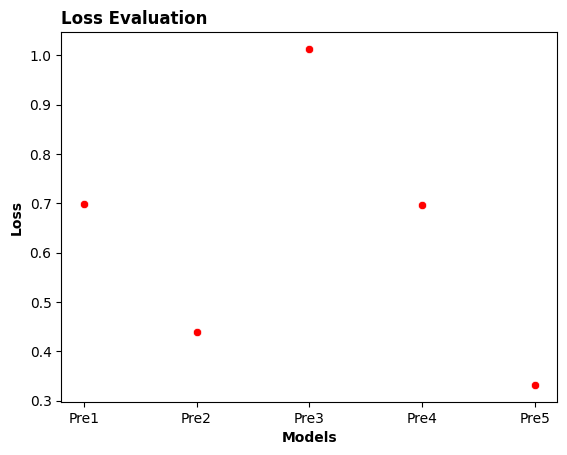

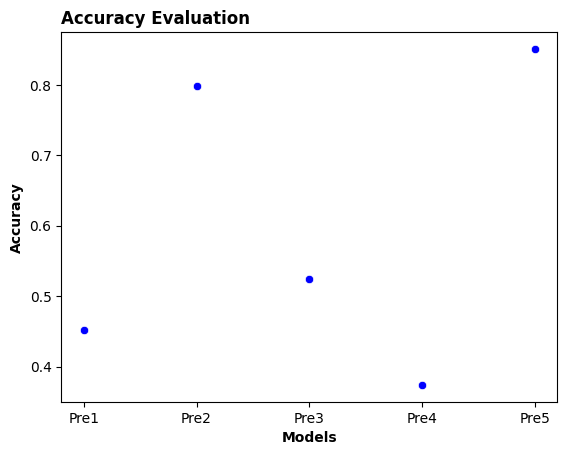

In [ ]:
#Loss Evaluation
sns.scatterplot(x=Models, y=Loss, color='red')
plt.xlabel("Models",fontdict={"size":10,"weight":'bold'})
plt.ylabel("Loss",fontdict={"size":10,"weight":'bold'})
plt.title("Loss Evaluation",loc='left',fontdict={"size":12,"weight":'bold'})
plt.show()

# Accuracy Evaluation
sns.scatterplot(x=Models, y=Accuracy,color='blue')
plt.xlabel("Models",fontdict={"size":10,"weight":'bold'})
plt.ylabel("Accuracy",fontdict={"size":10,"weight":'bold'})
plt.title("Accuracy Evaluation",loc='left',fontdict={"size":12,"weight":'bold'})
plt.show()
     

According to the provided plots, the 5th model, which used a simpler network and was trained on 15000 samples, was the best performer among all the models. This suggests that a simpler model can sometimes be more effective than a complex one.

When evaluating the Pre_Trained Models, it was observed that most of them were underfitting and were not able to comprehend the patterns and sentiments of the data they were trained on, leading to poor performance on unseen data. However, the final model was able to train well on the data and achieved the best results.

In the base models, different training sample sizes were used, and all the models performed well, with no underfitting observed. However, they started to overfit after a certain point. Using callbacks, a sweet spot was found and the test set was evaluated accordingly.

Fine-tuning the hyperparameters, such as learning rate, embedding vector dimension, Conv1D layers, Dense layers, nodes, and dropout rate, helped achieve the best performance with a training sample size of 35000.

From the evaluation of both pre-trained and base models, it can be concluded that understanding which knob to turn to improve the model's performance on the test set is essential. It is also important to monitor the model for underfitting or overfitting and adjust the parameters accordingly. Finally, a simple model can sometimes outperform a complex one.